# This task involves building a machine learning model to predict whether a patient will get a heart attack or not.

# Import Needed Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
import joblib

# Read Data
Data: CSV file containing patient health details and target
This file can be found here: https://drive.google.com/file/d/11EhzPifLLoK3Pmv0LDN-4rXavdmMH-IQ/view?usp=sharing


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/Siemens_Task/heart.csv'
data = pd.read_csv(data_path)

# Check for this DataFrame
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


# Data investigation

In [4]:
# View basic info about the Data
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None


In [5]:
# Check for missing values
print(data.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [6]:
# Check for duplicate rows
duplicates = data.duplicated()

# Count the number of duplicate rows
print(f"Number of duplicate rows: {duplicates.sum()}")


Number of duplicate rows: 1


Class counts:
target
1    165
0    138
Name: count, dtype: int64


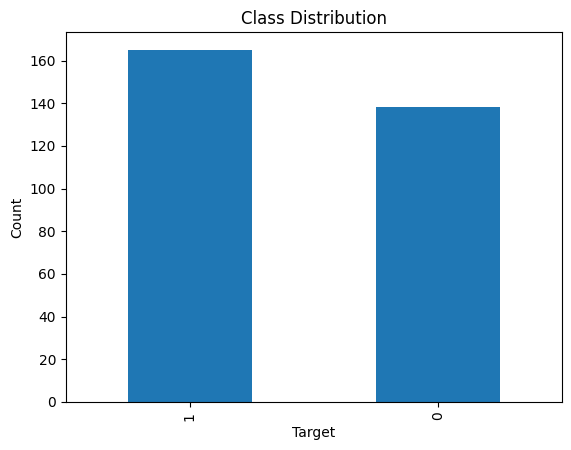

In [7]:
# Check if the data is Balanced
# Count instances for each class
class_counts = data['target'].value_counts()
print("Class counts:")
print(class_counts)

# Bar plot for class distribution
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


# Conclusion 1
- Data Types: float64(1), int64(13) -> no need for encoding
- NO Columns with NULL values
- Only One duplicated row (we can simply drop it).
- The dataset has some imbalance (we can keep this proportion during splitting, but no need for oversampling or downsampling).

In [8]:
# Columns Distibutions

descriptions={'age':'The age of the patient in years.',
              'sex':'The sex of the patient (Female, Male).',
              'cp':'The chest pain type (0 = Typical Angina, 1 = Atypical Angina, 2 = Non-anginal Pain, 3 = Asymptomatic).',
              'trestbps':'The resting blood pressure of the patient in mm Hg.',
              'chol':'The cholesterol level of the patient in mg/dl.',
              'fbs':'The fasting blood sugar level of the patient (0 = No sugar, 1 = yes >120 mg/dl ).',
              'restecg':'The Resting Electrocardiographic Results: 0 = Normal, 1 = Having ST-T wave abnormality, 2 = Showing probable or definite left ventricular hypertrophy.',
              'thalach':'The maximum heart rate achieved by the patient.',
              'exang':'Exercise induced angina (1 = yes; 0 = no)',
              'oldpeak':'The oldpeak: ST depression induced by exercise relative to rest.',
              'slope':'The slope of the peak exercise ST segment (0 = upsloping, 1 = flat, 2 = downsloping).',
              'ca':'The number of major vessels (0-3) colored by flourosopy.',
              'thal':'The thalassemia type (0 = normal, 1 = fixed defect, 2 = reversable defect).',
              'target':'The target variable (0 = no heart disease, 1 = heart disease).'}

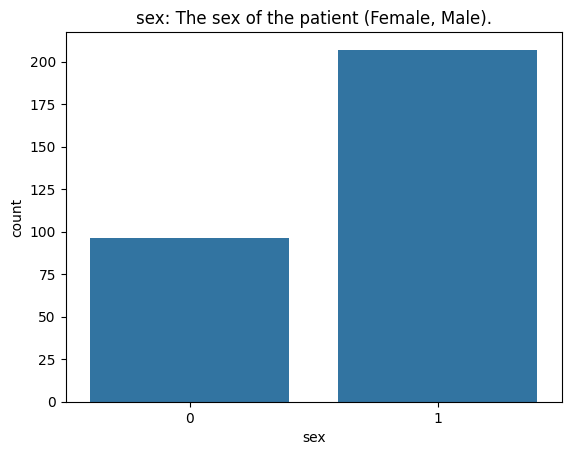

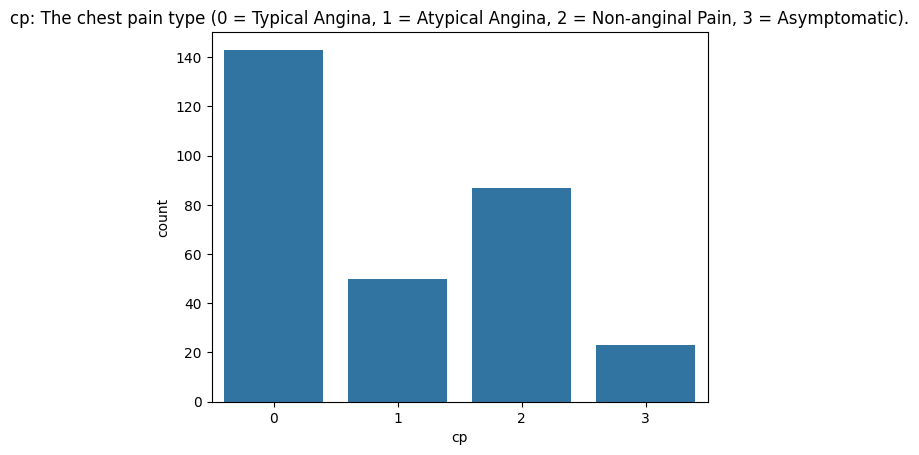

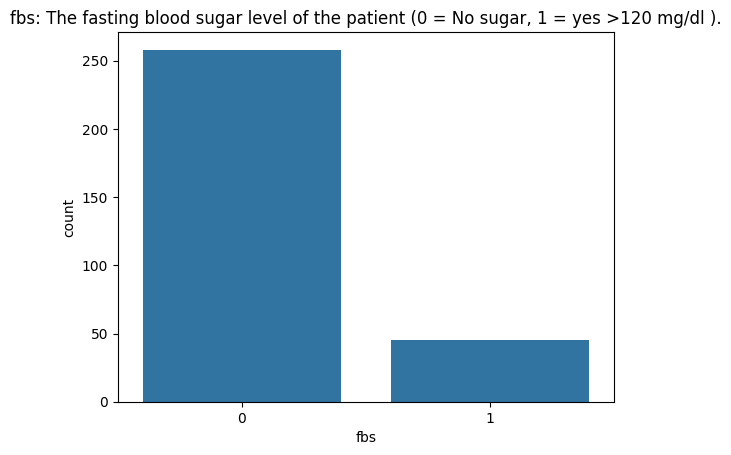

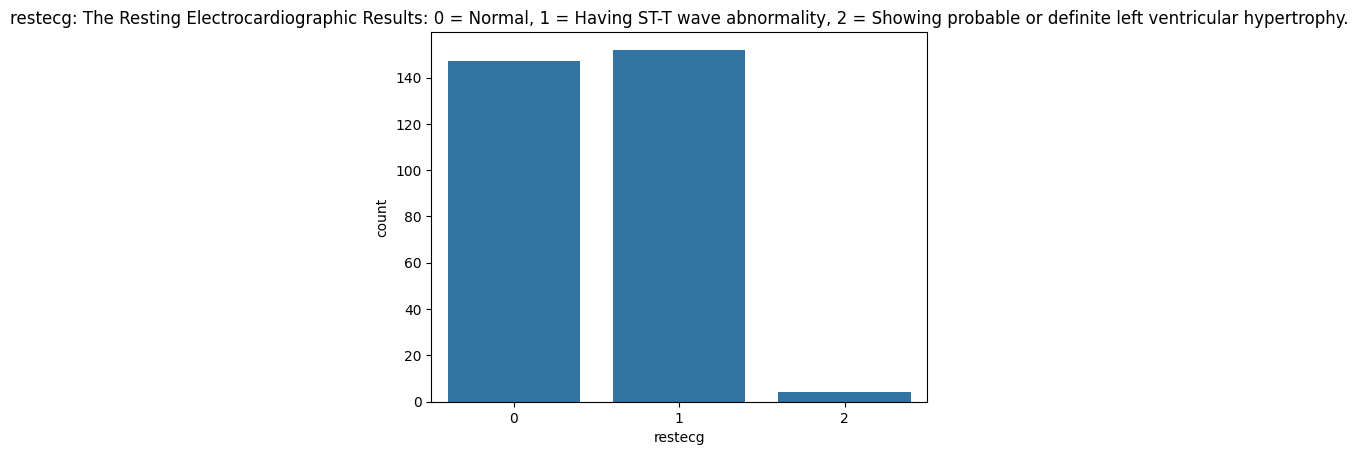

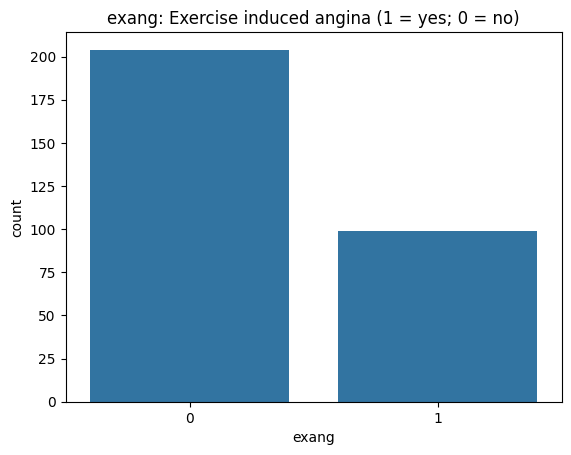

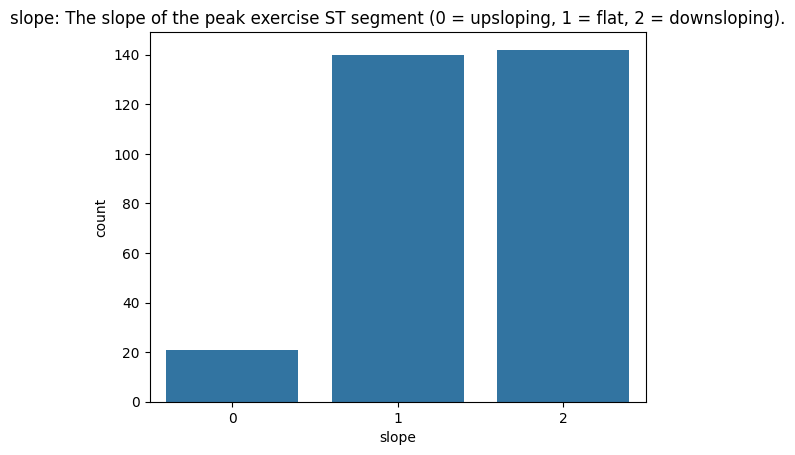

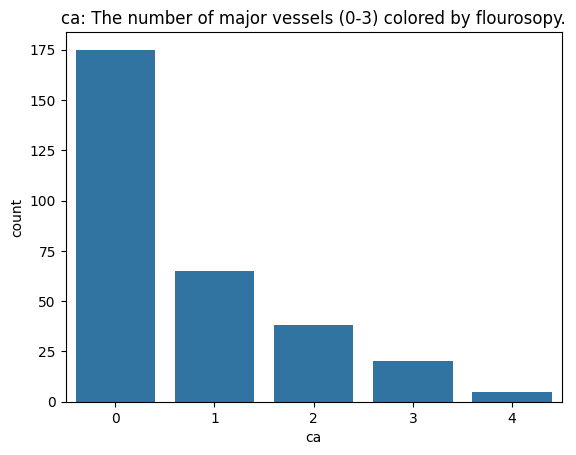

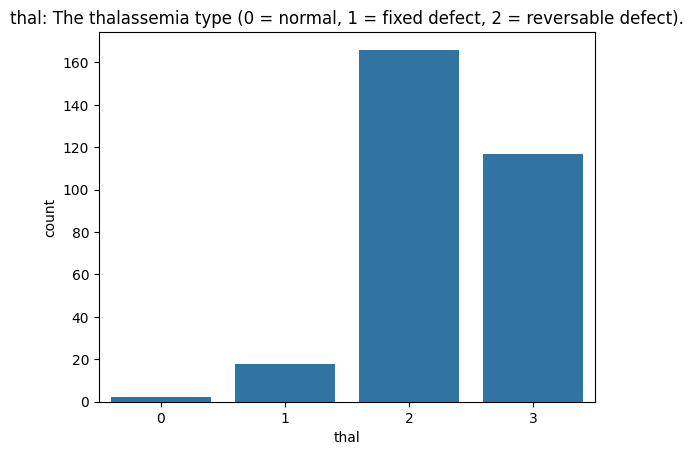

In [9]:
# Categorical features: bar plots
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
for col in categorical_columns:
    sns.countplot(x=col, data=data)
    plt.title(col+": "+descriptions[col])
    plt.show()

# Conclusion 2

- **sex**: There is a gender imbalance in the dataset, with males being twice as frequent as females.

- **cp**: Chest pain type 0 is the most common, while 3 is the least common.

- **fbs**: The vast majority of patients have a fasting blood sugar of ≤120 mg/dl (0).

- **restecg**: categories 0 and 1 are evenly distributed, but category 2 is rare.

- **exang**: Angina (1) is less common compared to no angina (0).

- **slope**: Slope categories 1 and 2 dominate, while 0 is rare.

- **ca**: Most patients have 0 major vessels colored, with a gradual decline in counts as the number increases reaching Rare category like 4.

- **thal**: 2 and 3 are the dominant categories, while 0 is extremely rare.

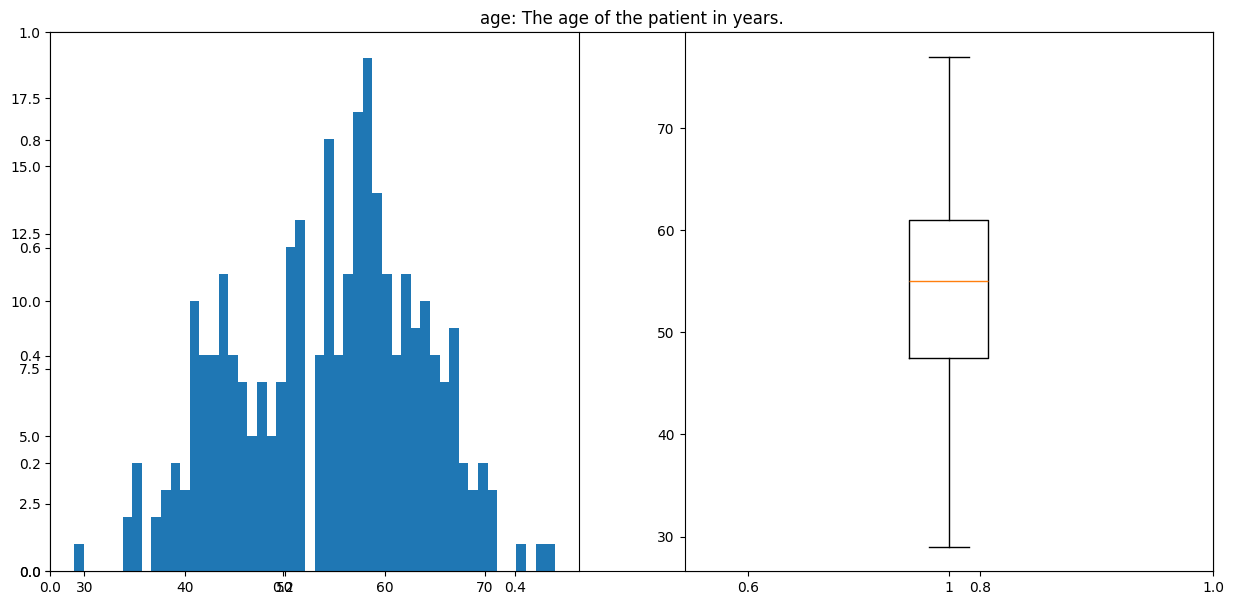

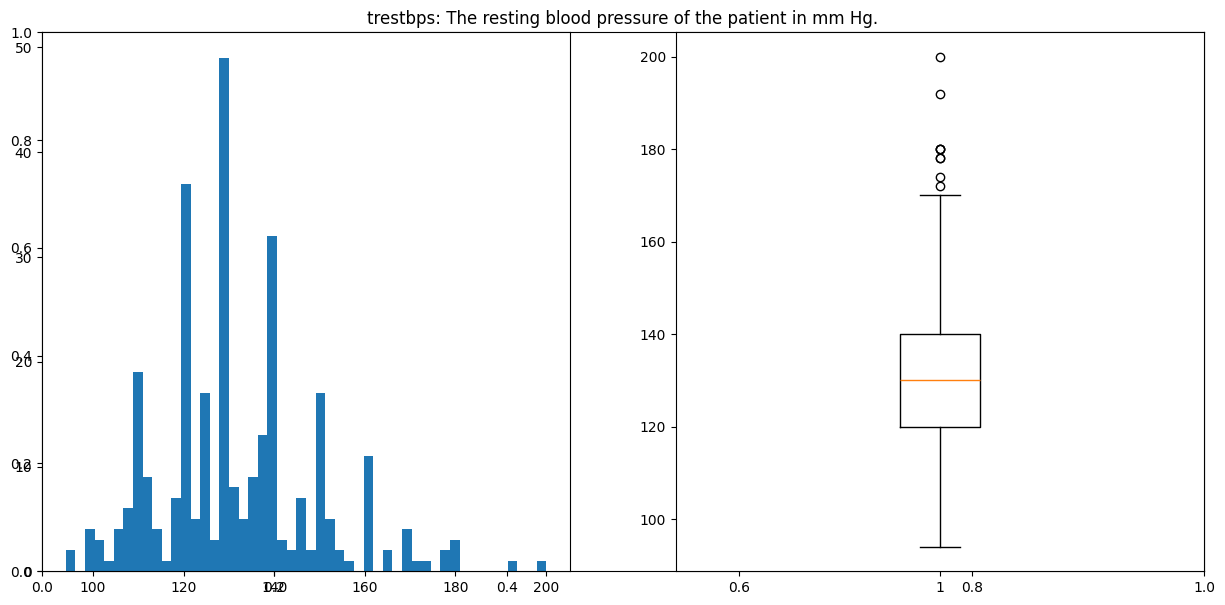

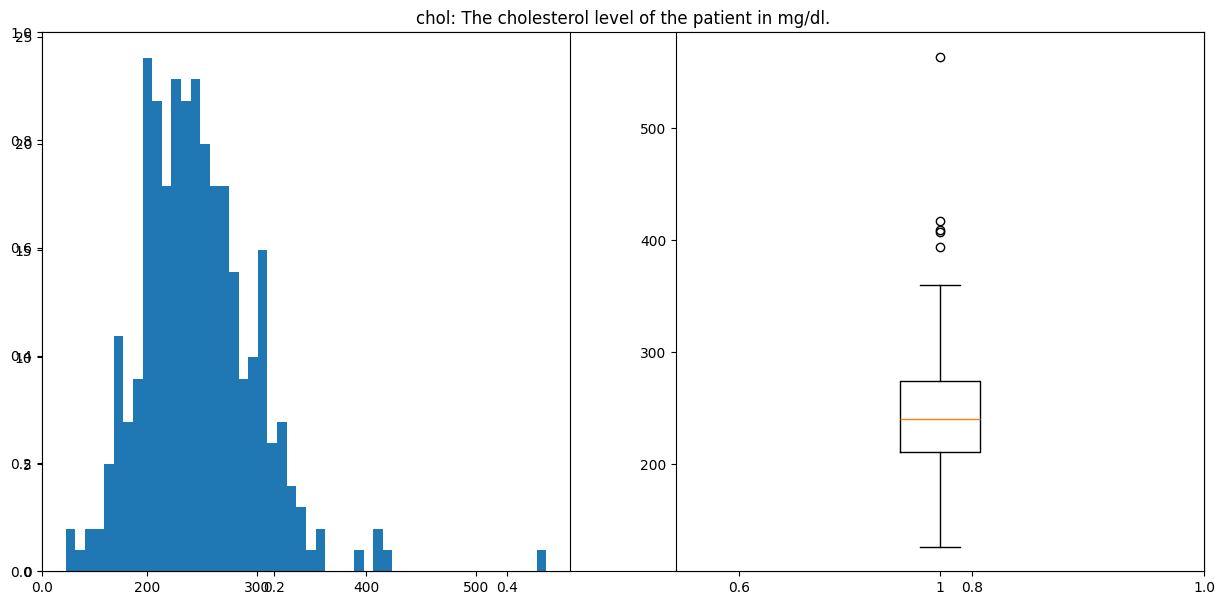

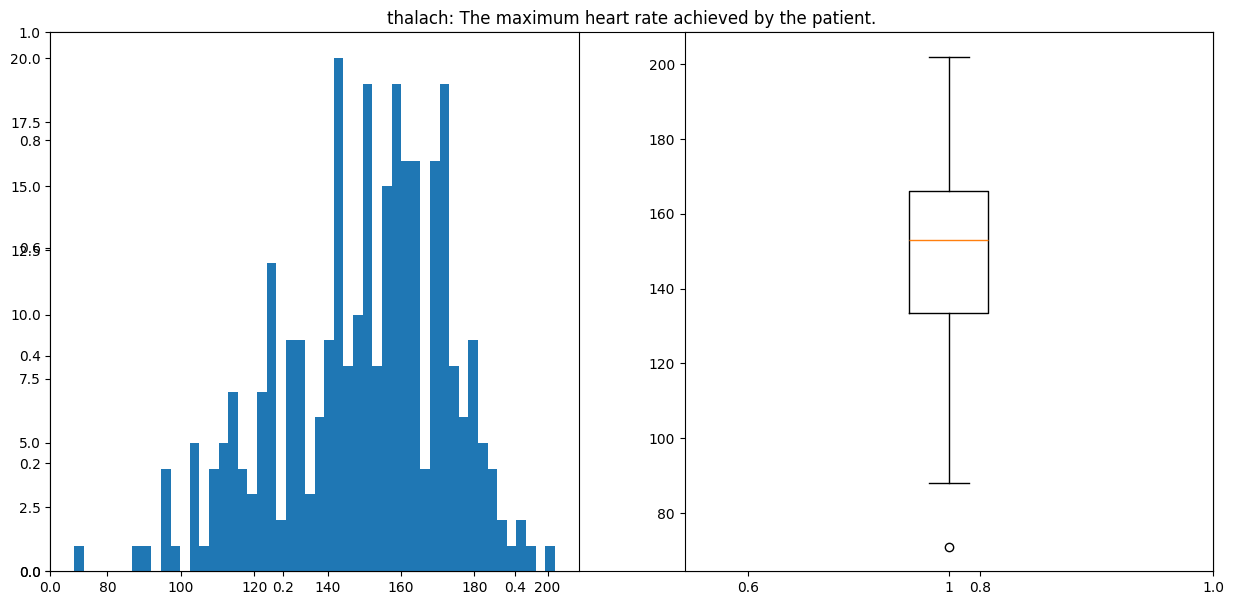

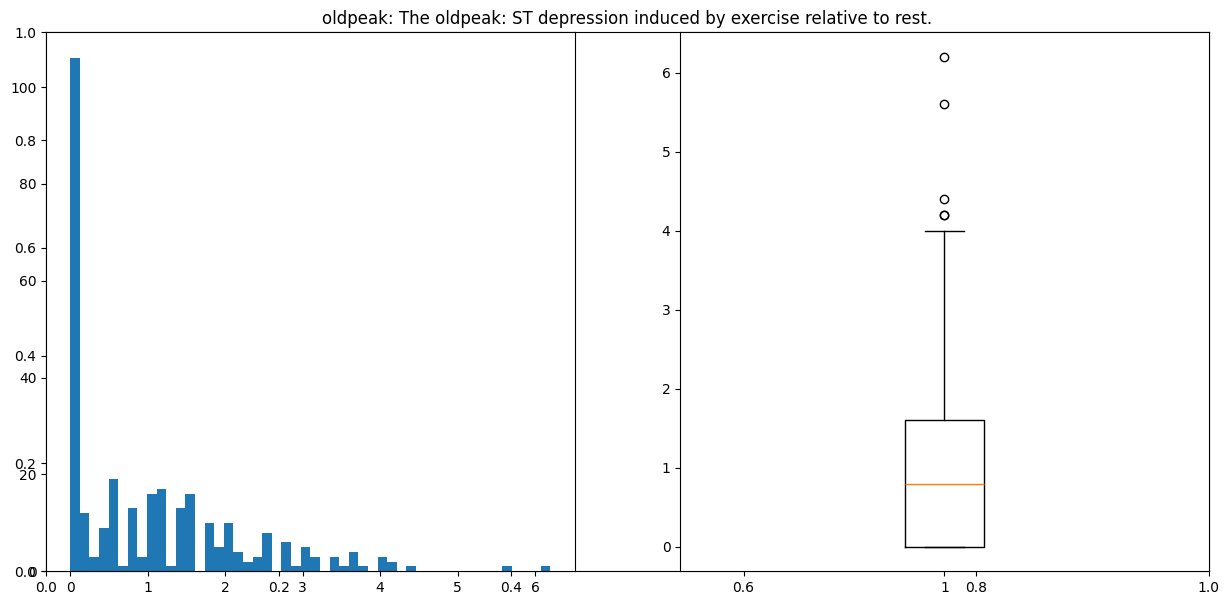

In [10]:
# Numerical Features: Histograms for Explore Distribution
numerical_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

for col in numerical_columns:
    plt.figure(figsize=(15,7))
    plt.title(col+": "+descriptions[col])
    #distribution
    plt.subplot(1, 2, 1)
    plt.hist(data[col],50)
    #check for outliers
    plt.subplot(1, 2, 2)
    plt.boxplot(data[col])
    plt.show()


In [11]:
data[numerical_columns].describe()

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604
std,9.082101,17.538143,51.830751,22.905161,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


# Conclusion 3
- Age and Thalach: These columns have almost normal distributions with no outliers. -> StandardScaler may be needed (not min_max sclare that there isn't high difference between min and max values).

- Trestbps, Chol: have some Outliers, but not high skewness -> RobustScaler.

- oldpeak: has high right skewness -> PowerTransformer.

In [14]:
# Compute correlation matrix
correlation_matrix = data.corr()


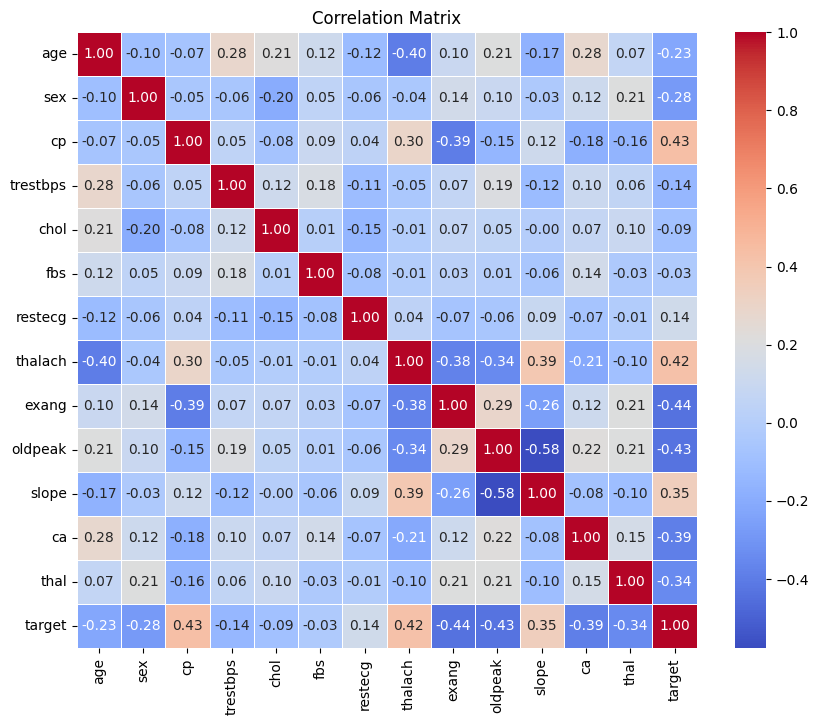

In [15]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)

# Display the plot
plt.title('Correlation Matrix')
plt.show()

# Conclusion 4
 - No need for feature selection that all features have almost same correlation with target.

# Data Splitting

In [16]:
# Drop duplicate rows
data = data.drop_duplicates()

# Verify the duplicates are removed -> Check for duplicate rows again
duplicates = data.duplicated()

# Count the number of duplicate rows
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


In [17]:
# Splitting the DataFrame 'data' into training and testing sets
# random_state=42 sets the random seed for reproducibility, ensuring the same random split every time the code is run
# test_size=0.2 specifies that 20% of the data will be used for testing, while 80% will be used for training
# Stratified splitting to maintain class distribution
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['target'], random_state=42)


# Splitting the DataFrame 'train_data' into training and validation sets
# test_size=0.2 specifies that 20% of the training data will be used for validation and the remaining will be kept for training
train_data, validation_data = train_test_split(train_data, random_state=42, test_size=0.2)

# Printing the shapes (number of rows and columns) of the training, validation and testing sets
print("train.shape= ", train_data.shape)  # Displaying the shape of the training set
print("validation.shape= ", validation_data.shape)    # Displaying the shape of the validation set
print("test.shape= ", test_data.shape)    # Displaying the shape of the testing set

train.shape=  (192, 14)
validation.shape=  (49, 14)
test.shape=  (61, 14)


In [18]:
# Extract features by dropping the target column -> X
# Extract target labels -> Y
X_train = train_data.drop('target', axis=1)
Y_train = train_data['target']
X_val= validation_data.drop('target', axis=1)
Y_val= validation_data['target']
X_test= test_data.drop('target', axis=1)
Y_test= test_data['target']

# Data Preprocessing


In [19]:
# Define the scalers for specific columns
scalers = ColumnTransformer([
    ('standard_scaler', StandardScaler(), ['age', 'thalach']),  # Almost normal distribution
    ('robust_scaler', RobustScaler(), ['trestbps', 'chol']),   # Outliers but not high skewness
    ('power_transformer', PowerTransformer(), ['oldpeak'])  # High skewness
], remainder='passthrough')  # Leave other columns as they are

# Fit and transform the training data
X_train_scaled = scalers.fit_transform(X_train)

# Transform the testing/validation data
X_val_scaled = scalers.transform(X_val)
X_test_scaled = scalers.transform(X_test)

# Classification Model

- F1_Score will be used as the evaluation metric since it's a kind of unbalanced dataset.

K-Nearest Neighbors

In [20]:
# Define the parameter grid
parameters_KNN = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
classifier_KNN = KNeighborsClassifier()

# Set up GridSearchCV with F1 score as the evaluation metric
grid_search_KNN = GridSearchCV(classifier_KNN, parameters_KNN, scoring='f1')

# Fit the model
grid_search_KNN.fit(X_train, Y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [21]:
# Get the best model from grid search
best_classifier_KNN = grid_search_KNN.best_estimator_

# Make predictions using the best model
Y_pred_KNN = best_classifier_KNN.predict(X_test)

# Evaluate the performance using f1_score
f1_KNN = f1_score(Y_test, Y_pred_KNN)

print(f"Best hyperparameters: {grid_search_KNN.best_params_}")
print(f"F1 Score for best KNN model: {f1_KNN} ")

Best hyperparameters: {'n_neighbors': 3, 'weights': 'uniform'}
F1 Score for best KNN model: 0.5846153846153846 


Decision Tree

In [22]:
# Define the parameter grid
parameters_DT = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}

classifier_DT = DecisionTreeClassifier(random_state=0)

# Set up GridSearchCV with F1 score as the evaluation metric
grid_search_DT = GridSearchCV(classifier_DT, parameters_DT, scoring='f1')

# Fit the model
grid_search_DT.fit(X_train, Y_train)


GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1')

In [23]:
# Get the best model from grid search
best_classifier_DT = grid_search_DT.best_estimator_

# Make predictions using the best model
Y_pred_DT = best_classifier_DT.predict(X_test)

# Evaluate the performance using f1_score
f1_DT = f1_score(Y_test, Y_pred_DT)

print(f"Best hyperparameters: {grid_search_DT.best_params_}")
print(f"F1 Score for best Decision Tree model: {f1_DT} ")

Best hyperparameters: {'max_depth': None, 'min_samples_split': 2}
F1 Score for best Decision Tree model: 0.75 


LogisticRegression

In [24]:
# Define the parameter grid
parameters_logistic = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2', 'none']}
classifier_logistic = LogisticRegression(random_state=0)

# Set up GridSearchCV with F1 score as the evaluation metric
grid_search_logistic = GridSearchCV(classifier_logistic, parameters_logistic, scoring='f1')

# Fit the model
grid_search_logistic.fit(X_train, Y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l2', 'none']},
             scoring='f1')

In [25]:
# Get the best model from grid search
best_classifier_logistic = grid_search_logistic.best_estimator_

# Make predictions using the best model
Y_pred_logistic = best_classifier_logistic.predict(X_test)

# Evaluate the performance using f1_score
f1_logistic = f1_score(Y_test, Y_pred_logistic)

print(f"Best hyperparameters: {grid_search_logistic.best_params_}")
print(f"F1 Score for best Logistic Regression model: {f1_logistic} ")

Best hyperparameters: {'C': 0.1, 'penalty': 'l2'}
F1 Score for best Logistic Regression model: 0.8 


Random Forest

In [26]:
# Define the parameter grid
parameters_RF = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
classifier_RF = RandomForestClassifier(random_state=0)

# Set up GridSearchCV with F1 score as the evaluation metric
grid_search_RF = GridSearchCV(classifier_RF, parameters_RF, scoring='f1')

# Fit the model
grid_search_RF.fit(X_train, Y_train)


GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [27]:
# Get the best model from grid search
best_classifier_RF = grid_search_RF.best_estimator_

# Make predictions using the best model
Y_pred_RF = best_classifier_RF.predict(X_test)

# Evaluate the performance using f1_score
f1_RF = f1_score(Y_test, Y_pred_RF)

print(f"Best hyperparameters: {grid_search_RF.best_params_}")
print(f"F1 Score for best Random Forest model: {f1_RF} ")

Best hyperparameters: {'max_depth': None, 'n_estimators': 50}
F1 Score for best Random Forest model: 0.8055555555555556 


Naive Bayes

In [28]:
classifier_NB = GaussianNB()

# Fit the model
classifier_NB.fit(X_train, Y_train)

GaussianNB()

In [29]:
# Make predictions using the best model
Y_pred_NB = classifier_NB.predict(X_test)

# Evaluate the performance using f1_score
f1_NB = f1_score(Y_test, Y_pred_NB)

print(f"F1 Score for best NB model: {f1_NB} ")

F1 Score for best NB model: 0.8285714285714286 


SVM

In [34]:
# Define the parameter grid for SVM
parameters_SVM = {
    'C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel types
    'degree': [2, 3, 4]  # Degree of the polynomial kernel (only for 'poly')
}

# Initialize the SVM classifier
classifier_SVM = SVC(random_state=0)

# Set up GridSearchCV
grid_search_SVM = GridSearchCV(classifier_SVM, parameters_SVM, cv=5, scoring='f1')

# Fit the grid search
grid_search_SVM.fit(X_train, Y_train)


GridSearchCV(cv=5, estimator=SVC(random_state=0),
             param_grid={'C': [0.01, 0.1, 1, 10], 'degree': [2, 3, 4],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='f1')

In [35]:
# Get the best model from grid search
best_classifier_SVM = grid_search_SVM.best_estimator_

# Make predictions using the best model
Y_pred_SVM = best_classifier_SVM.predict(X_test)

# Evaluate the performance using f1_score
f1_SVM = f1_score(Y_test, Y_pred_SVM)

print(f"Best hyperparameters: {grid_search_SVM.best_params_}")
print(f"F1 Score for best Random Forest model: {f1_SVM} ")

Best hyperparameters: {'C': 1, 'degree': 2, 'kernel': 'linear'}
F1 Score for best Random Forest model: 0.8333333333333334 


# Found SVM is the best Classfifier with Parameters {'C': 1, 'kernel': 'linear'} and Score(0.8333333333333334 ) for F1_Score


In [44]:
# Merge the training and validation sets into one dataframe
train_data = pd.concat([train_data, validation_data], ignore_index=True)

X_train= train_data.drop('target', axis=1)
Y_train= train_data['target']

# Retrain Classifier on the combined dataset
final_classifier = SVC(C=1, kernel='linear')
final_classifier.fit(X_train, Y_train)

SVC(C=1, kernel='linear')

In [45]:
# Final Results
# Make predictions on the training and test sets using selected classifier
train_y_predicted = final_classifier.predict(X_train)  # Predictions on the training set
test_y_predicted = final_classifier.predict(X_test)  # Predictions on the test set

train_score=f1_score(Y_train, train_y_predicted)  # Calculate F1 score for training set predictions
test_score=f1_score(Y_test, test_y_predicted)  # Calculate F1 score for validation set predictions

# Print the final train and test F1 scores
print("train_score= ",train_score)
print("test_score= ",test_score)

train_score=  0.8855721393034826
test_score=  0.8266666666666667


In [46]:
# Save the best model
model_filename = f"Classification_best_model.pkl"
joblib.dump(final_classifier, model_filename)

['Classification_best_model.pkl']

In [47]:
# Load the saved model
loaded_model = joblib.load(model_filename)
print(f"Loaded model: {loaded_model}")

# Use the loaded model for predictions
test_predictions = loaded_model.predict(X_test)
print(f"Test Predictions: {test_predictions}")

# Evaluate the loaded model
test_score = f1_score(Y_test,test_predictions)
print(f"Test Score: {test_score}")

Loaded model: SVC(C=1, kernel='linear')
Test Predictions: [0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1
 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1]
Test Score: 0.8266666666666667


# Done!